- Primera iteracion para aprender a cargar datos desde datasets de Roboflow
- Tambien se entrena un modelo (sin transfer learning ni nada, el mas basico) que viene por defecto de YOLO

In [ ]:
'''
YOLO 8 !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="tvpbe4I4XLcB14dkNovn")
project = rf.workspace("myworkspace-iraqv").project("wildfire_full")
version = project.version(1)
dataset = version.download("yolov8")'''

'\nYOLO 8 !pip install roboflow\n\nfrom roboflow import Roboflow\nrf = Roboflow(api_key="tvpbe4I4XLcB14dkNovn")\nproject = rf.workspace("myworkspace-iraqv").project("wildfire_full")\nversion = project.version(1)\ndataset = version.download("yolov8")'

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="tvpbe4I4XLcB14dkNovn")
project = rf.workspace("myworkspace-iraqv").project("wildfire_full")
version = project.version(1)
dataset = version.download("tensorflow")


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
#!pip install opencv-python-headless==4.10.0.84

In [ ]:
#! pip install ultralytics


In [ ]:
import os

print(os.listdir('Wildfire_Full-1'))

['train', 'README.roboflow.txt', 'valid', 'test', 'README.dataset.txt']


In [ ]:
# Verifica la ruta absoluta del archivo
train_data_path = os.path.abspath('Wildfire_Full-1/train/')
print("Ruta completa al dataset de train:", train_data_path)

test_data_path = os.path.abspath('Wildfire_Full-1/test/')
print("Ruta completa al dataset de train:", test_data_path)

valid_data_path = os.path.abspath('Wildfire_Full-1/valid/')
print("Ruta completa al dataset de train:", valid_data_path)

Ruta completa al dataset de train: /content/Wildfire_Full-1/train
Ruta completa al dataset de train: /content/Wildfire_Full-1/test
Ruta completa al dataset de train: /content/Wildfire_Full-1/valid


In [ ]:
# Veamos algunas imagenes y definamos el archivo con las annotaciones de los bb en entrenamiento:
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd


train_annotations_path = os.path.join(train_data_path, '_annotations.csv')
# Cargar las anotaciones
train_annotations = pd.read_csv(train_annotations_path)
print("Estructura de las anotaciones:")
train_annotations.head()

Estructura de las anotaciones:


,filename,width,height,class,xmin,ymin,xmax,ymax
0,52355484724_b8cb1c7bb1_o_jpg.rf.456de39a89a9aa...,640,640,Smoke,0,0,640,312
1,43251632962_0a4d318bba_o_jpg.rf.43b681e5a68c85...,640,640,Smoke,0,0,173,325
2,43251632962_0a4d318bba_o_jpg.rf.43b681e5a68c85...,640,640,Smoke,140,37,279,278
3,43251632962_0a4d318bba_o_jpg.rf.43b681e5a68c85...,640,640,Smoke,334,68,596,213
4,50295006206_a6250175c7_o_jpg.rf.3f6a2a15bf5c9e...,640,640,Fire,335,402,362,443


In [ ]:
missing_id = 481
# laimagen sin el bb no nos aparece
train_annotations.loc[479:483]

,filename,width,height,class,xmin,ymin,xmax,ymax
479,50246118707_cfe8f84230_o_jpg.rf.6f524c01c635dd...,640,640,Smoke,166,51,438,306
480,34182401245_908ac4708b_o_jpg.rf.7935673e6f438e...,640,640,Smoke,342,71,520,362
481,34182401245_908ac4708b_o_jpg.rf.7935673e6f438e...,640,640,Smoke,146,141,343,331
482,52530251251_af8b68b64e_o_jpg.rf.84cf1a5e7e477b...,640,640,Fire,26,487,46,500
483,52530251251_af8b68b64e_o_jpg.rf.84cf1a5e7e477b...,640,640,Fire,79,450,202,468


# Visualizamos algunas imagenes con sus bb:

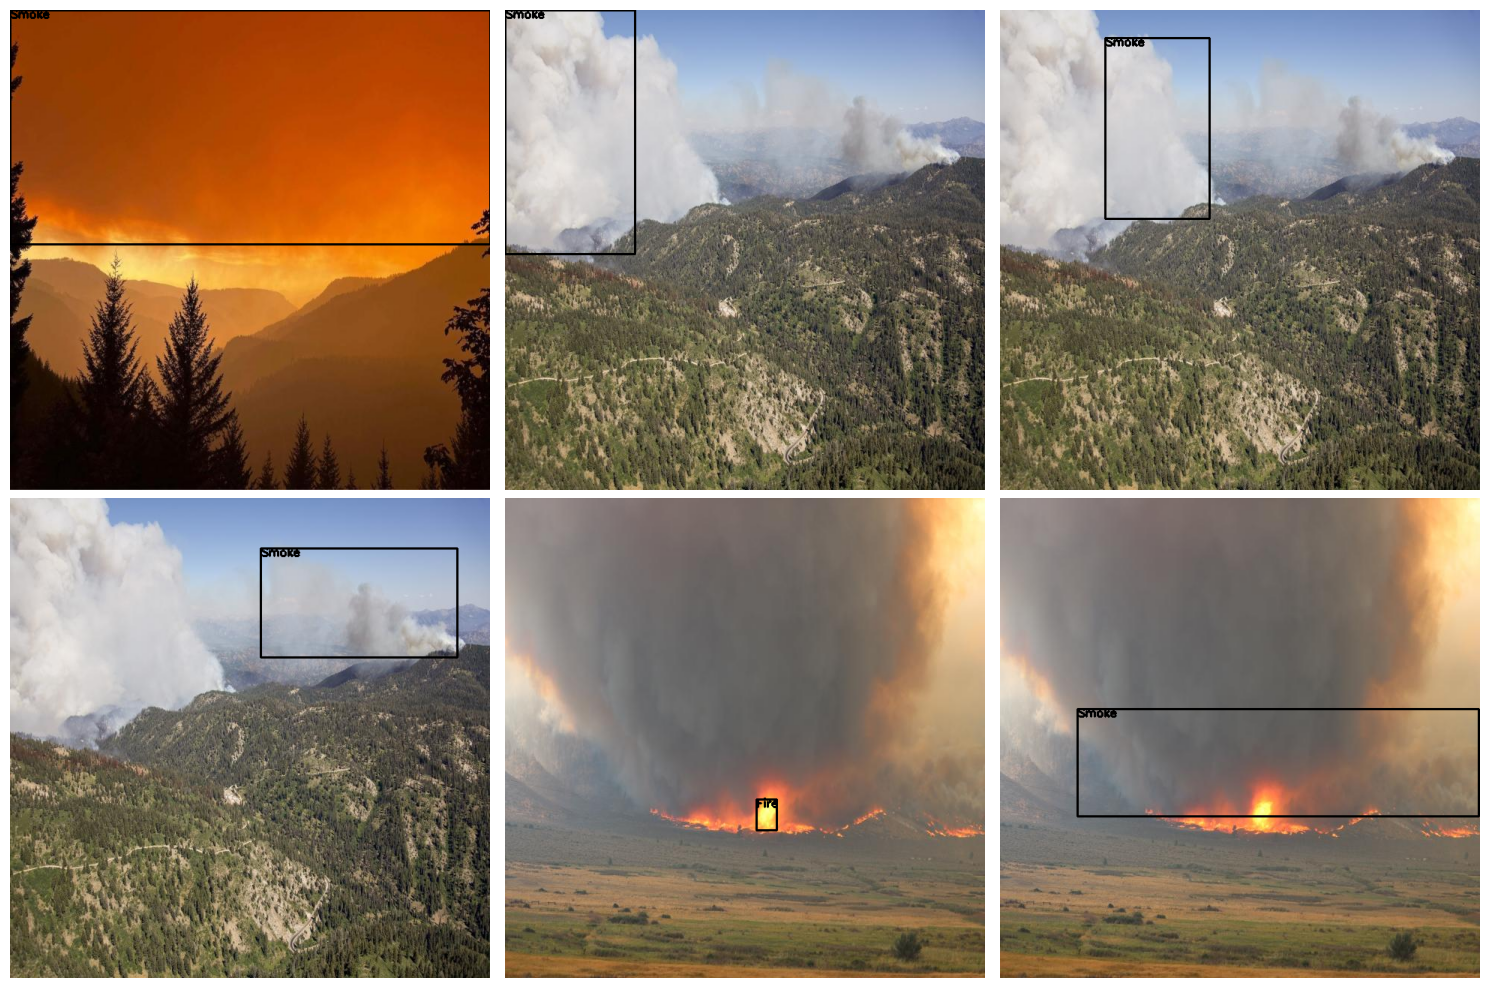

In [ ]:
import random

# Seleccionar las primeras 6 imágenes con sus bounding boxes
subset_annotations = train_annotations.iloc[:6]

# Crear una figura para mostrar 6 imágenes
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

for i, (_, row) in enumerate(subset_annotations.iterrows()):
    # Cargar la imagen
    image_path = os.path.join(train_data_path, row['filename'])
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Dibujar el bounding box
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    label = row['class'] if 'class' in row else 'Object'
    cv.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 0), 2)

    # Agregar el texto del label
    font = cv.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 2
    cv.putText(image, label, (xmin, ymin + 10), font, font_scale, (0, 0, 0), thickness)

    # Mostrar la imagen en la subtrama
    axs[i].imshow(image)
    #axs[i].set_title(row['filename'])
    axs[i].axis('off')

plt.tight_layout()


Ya que el dataset no tiene Data Augmentation, vemos conveniente realizar:
- **Rotaciones**: ayudaria al modelo a generalizar para diferentes perspectivas.
- **Escalado**: tal de qumentar la variabilidad en las distancias de captura (cerca o lejos del foco del incendio).
- **Horizontal flip**: tal que el modelo pueda inferir con mas datos.
- **Variación de brillo y contraste**: Ajustar el brillo y el contraste ayuda a simular condiciones de luz variables.
- **Desenfoque (blur)**: Podria ayudar al modelo generalizar ya que el blur representa el movimiento del fuego capturado en imágenes de baja velocidad de obturación o imágenes tomadas con movimiento
- **Recortes aleatorios**: Útil para enseñar al modelo a identificar incendios cuando solo una parte del incendio es visible.
- **Zoom in y out**: Ayuda a simular escenarios donde el incendio es observado desde diferentes distancias.

Al hacer DataAugmentation hay que considerar los bb nuevos:
https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [ ]:
#Procedemos:
import albumentations as A
from albumentations import (
    Rotate, HorizontalFlip, RandomBrightnessContrast, GaussianBlur, RandomResizedCrop, Resize, Compose
)
from albumentations.core.bbox_utils import convert_bboxes_to_albumentations, convert_bboxes_from_albumentations
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Paths
train_data_path = "/content/Wildfire_Full-1/train"
train_annotations_path = os.path.join(train_data_path, '_annotations.csv')

# Load annotations
annotations = pd.read_csv(train_annotations_path)

# Helper to load images and annotations
def load_image_and_bboxes(row):
    img_path = os.path.join(train_data_path, row['filename'])
    image = cv.imread(img_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # Convert to RGB

    # Bounding boxes: format [x_min, y_min, width, height, label]
    bboxes = [[row['xmin'], row['ymin'], row['xmax'], row['ymax'], row['class']]]
    return image, bboxes

# Data augmentation pipeline
augmentation_pipeline = Compose([
    Rotate(limit=25, p=0.5),  # Rotación limitada a ±25 grados con probabilidad de 50%
    HorizontalFlip(p=1),  # Horizontal flip, para todas las imagenes, asi se tiene mayor cantidad de datos
    RandomBrightnessContrast(p=0.7),  # Brightness and contrast variation
    GaussianBlur(blur_limit=(3, 5), p=0.5),  # Random blur al 50%
    #RandomResizedCrop(height=512, width=512, scale=(0.9, 1.0), p=1),  # Esta linea dio problemas en la posterior ubicacion de los bb, asi que se tomo un valor mas conservador
], bbox_params=A.BboxParams(format='pascal_voc', min_area=700, min_visibility=0.2, label_fields=['category']))

# Output folder for augmented data
augmented_data_path = os.path.join(train_data_path, 'augmented')
os.makedirs(augmented_data_path, exist_ok=True)

augmented_annotations = []

# Aplicar data augmentation y guardar anotaciones en el formato esperado
for _, row in tqdm(annotations.iterrows(), total=len(annotations)):
    image, bboxes = load_image_and_bboxes(row)

    # Albumentations espera las coordenadas en formato [xmin, ymin, xmax, ymax]
    albumentations_bboxes = [[row['xmin'], row['ymin'], row['xmax'], row['ymax']]]
    labels = [row['class']]  # Etiqueta asociada al bbox

    # Aplicar augmentación
    augmented = augmentation_pipeline(
        image=image,
        bboxes=albumentations_bboxes,
        category=labels  # Las etiquetas deben coincidir con los bboxes
    )

    augmented_image = augmented['image']
    augmented_bboxes = augmented['bboxes']  # Ya en formato Pascal VOC

    # Guardar imagen augmentada
    augmented_filename = f"aug_{row['filename']}"
    augmented_image_path = os.path.join(augmented_data_path, augmented_filename)
    cv.imwrite(augmented_image_path, cv.cvtColor(augmented_image, cv.COLOR_RGB2BGR))

    # Obtener el tamaño de la imagen augmentada
    height, width = augmented_image.shape[:2]

    # Guardar bounding boxes augmentados con las columnas adicionales
    for bbox, label in zip(augmented_bboxes, labels):
        xmin, ymin, xmax, ymax = bbox
        augmented_annotations.append({
            'filename': augmented_filename,
            'width': width,
            'height': height,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax,
            'class': label
        })

# Guardar las anotaciones augmentadas en un archivo CSV
augmented_annotations_df = pd.DataFrame(augmented_annotations)
augmented_annotations_df.to_csv(os.path.join(augmented_data_path, '_augmented_annotations.csv'), index=False)

print("Data augmentation completed!")

A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
100%|██████████| 2014/2014 [00:41<00:00, 48.84it/s]

Data augmentation completed!


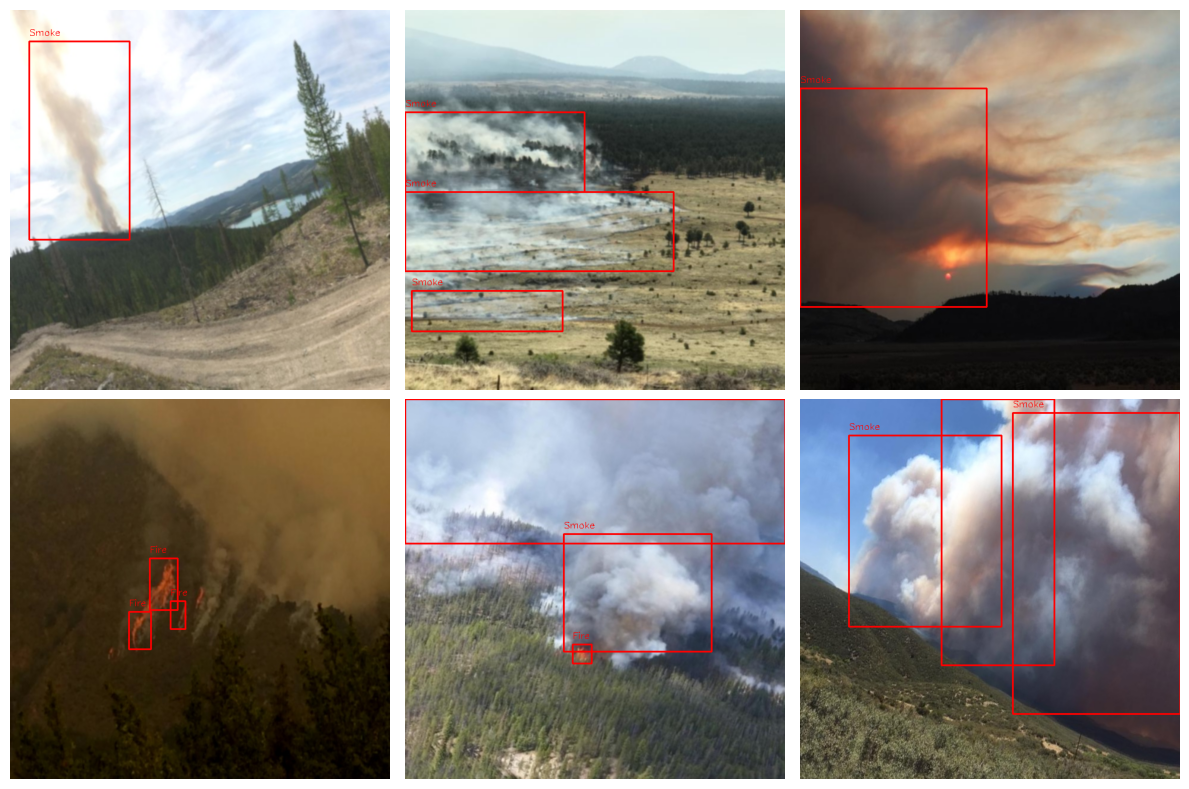

In [ ]:
#Ahora visualicemos algunas imagenes augmentadas:

# Cargar las anotaciones del dataset augmentado
augmented_annotations_path = os.path.join(augmented_data_path, '_augmented_annotations.csv')
augmented_annotations = pd.read_csv(augmented_annotations_path)

# Seleccionar aleatoriamente 6 imágenes con sus bounding boxes
random_filenames = random.sample(list(augmented_annotations['filename'].unique()), 6)
subset_annotations = augmented_annotations[augmented_annotations['filename'].isin(random_filenames)]

# Crear una figura para mostrar 6 imágenes
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()

for i, filename in enumerate(random_filenames):
    # Cargar la imagen
    image_path = os.path.join(augmented_data_path, filename)
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Dibujar los bounding boxes de la imagen seleccionada
    image_bboxes = subset_annotations[subset_annotations['filename'] == filename]
    for _, bbox_row in image_bboxes.iterrows():
        xmin, ymin, xmax, ymax = int(bbox_row['xmin']), int(bbox_row['ymin']), int(bbox_row['xmax']), int(bbox_row['ymax'])
        label = bbox_row['class'] if 'class' in bbox_row else 'Object'
        cv.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)  # Azul para los bounding boxes
        font = cv.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        thickness = 1
        cv.putText(image, label, (xmin, ymin - 10), font, font_scale, (255, 0, 0), thickness)

    # Mostrar la imagen en la subtrama
    axs[i].imshow(image)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# con el dataset completo, procedemos a normalizar las imagenes para que los calculos del gradiente
# en entrenamiento converjan.

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# Dataset combinado -> Augmentado + normal
combined_annotations = pd.concat([train_annotations, augmented_annotations], ignore_index=True)

# Función para normalizar imágenes y preparar anotaciones
def data_generator(annotations, train_image_path, augmented_image_path, batch_size=32):
    """Generador para cargar imágenes y anotaciones en lotes."""
    num_samples = len(annotations)
    label_mapping = {label: idx for idx, label in enumerate(set(annotations['class']))}  # Mapear etiquetas a índices

    while True:  # Generador infinito para entrenamiento
        for offset in range(0, num_samples, batch_size):
            # Seleccionar un lote de datos
            batch_annotations = annotations.iloc[offset:offset+batch_size]

            images = []
            bboxes = []
            labels = []

            for _, row in batch_annotations.iterrows():
                # Determinar si la imagen es augmentada
                if row['filename'].startswith('aug_'):
                    image_path = os.path.join(augmented_image_path, row['filename'])
                else:
                    image_path = os.path.join(train_image_path, row['filename'])

                # Leer y procesar la imagen
                image = cv.imread(image_path)
                if image is None:
                    print(f"Error: No se encontró la imagen {image_path}")
                    continue

                image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                image = cv.resize(image, (224, 224))
                image = image / 255.0

                # Procesar bounding boxes y etiquetas
                width, height = row['width'], row['height']
                xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

                scaled_bbox = [
                    xmin / width,
                    ymin / height,
                    xmax / width,
                    ymax / height
                ]

                images.append(image)
                bboxes.append(scaled_bbox)
                labels.append(label_mapping[row['class']])  # Convertir etiquetas a índices numéricos

            # Convertir a numpy arrays
            images = np.array(images, dtype=np.float32)
            bboxes = np.array(bboxes, dtype=np.float32)
            labels = np.array(labels, dtype=np.int64)  # Etiquetas en formato numérico

            yield images, {'bboxes': bboxes, 'labels': labels}

# Ejemplo de uso del generador
batch_size = 32
generator = data_generator(
    annotations=combined_annotations,
    train_image_path=train_data_path,
    augmented_image_path=augmented_data_path,
    batch_size=batch_size
)

# Probar el generador
images, targets = next(generator)
print(f"Batch size: {len(images)}")
print(f"Bounding boxes shape: {targets['bboxes'].shape}")
print(f"Labels shape: {len(targets['labels'])}")


Batch size: 32
Bounding boxes shape: (32, 4)
Labels shape: 32


In [ ]:
# Idem para el dataset de validation:
def validation_generator(annotations, valid_image_path, batch_size=32):
    """Generador para cargar imágenes y anotaciones de validación en lotes."""
    num_samples = len(annotations)
    label_mapping = {'Smoke': 0, 'Fire': 1}#, 'None': 2}  # Incluye la clase 'None' para casos sin detección??: esto esta dudoso, CONSULTAR

    while True:  # Generador infinito para validación
        for offset in range(0, num_samples, batch_size):
            # Seleccionar un lote de datos
            batch_annotations = annotations.iloc[offset:offset+batch_size]

            images = []
            bboxes = []
            labels = []

            for _, row in batch_annotations.iterrows():
                image_path = os.path.join(valid_image_path, row['filename'])

                # Leer y procesar la imagen
                image = cv.imread(image_path)
                if image is None:
                    print(f"Error: No se encontró la imagen {image_path}")
                    continue

                image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                image = cv.resize(image, (224, 224))
                image = image / 255.0

                # Procesar bounding boxes y etiquetas
                width, height = row['width'], row['height']
                xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

                scaled_bbox = [
                    xmin / width,
                    ymin / height,
                    xmax / width,
                    ymax / height
                ]

                images.append(image)
                bboxes.append(scaled_bbox)
                labels.append(label_mapping[row['class']])  # Donde label_mapping es {'Smoke': 0, 'Fire': 1}

            # Convertir a numpy arrays
            images = np.array(images, dtype=np.float32)
            bboxes = np.array(bboxes, dtype=np.float32)
            labels = np.array(labels, dtype=np.int64)  # Etiquetas en formato numérico

            yield images, {'bboxes': bboxes, 'labels': labels}

# Crear el generador de validación
validation_generator_instance = validation_generator(
    annotations=pd.read_csv('/content/Wildfire_Full-1/valid/_annotations.csv'),
    valid_image_path='/content/Wildfire_Full-1/valid',
    batch_size=32
)


In [ ]:
validation_annotations_path = "/content/Wildfire_Full-1/valid/_annotations.csv"
validation_annotations = pd.read_csv(validation_annotations_path)


# Definicion del BackBone del modelo de CV:

2. Flujo para usar ResNet50

- a. Configurar ResNet50 como Backbone
Usa ResNet50 preentrenado en ImageNet para aprovechar sus características ya aprendidas.
Congela las primeras capas para preservar estas características.
Añade nuevas capas personalizadas para bounding boxes y clasificación de objetos.
- b. Arquitectura del Modelo
Backbone (ResNet50):
Se elimina la última capa densa de ResNet50 (include_top=False) para usar únicamente las características convolucionales.
Cabeza personalizada:
Añade:
Una salida para bounding boxes (4 valores: xmin, ymin, xmax, ymax).
Una salida para clasificación (número de clases en el dataset).
- c. Pérdidas y Métricas
Bounding Boxes:
Pérdida de regresión (MSE o MAE).
Clasificación:
Pérdida de entropía cruzada categórica.
- d. Entrenamiento
Congela las capas iniciales de ResNet50 y entrena solo las capas personalizadas.
Opcionalmente, descongela gradualmente las capas de ResNet50 para ajustar finamente el modelo.

In [ ]:
#Conformes, procedemos a definir el backbone del modelo de CV:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model

# Cargar ResNet50 preentrenado
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas iniciales
for layer in resnet_base.layers[:140]:  # Congelar las primeras 140 capas
    layer.trainable = False

# Construir las cabezas personalizadas
x = Flatten()(resnet_base.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Salida para clasificación binaria (2 clases): smoke, fire
class_output = Dense(1, activation='sigmoid', name='labels')(x)


# Salida para bounding boxes -> 4 posiciones
bbox_output = Dense(4, activation='sigmoid', name='bboxes')(x)

# Crear el modelo
model = Model(inputs=resnet_base.input, outputs=[bbox_output, class_output])

# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'bboxes': 'mse',  # Para bounding boxes
        'labels': 'binary_crossentropy'  # Para clasificación multiclase
    },
    metrics={
        'bboxes': 'mae',  # Error medio absoluto para bounding boxes
        'labels': 'accuracy'  # Precisión para clasificación
    }
)


print(model.summary())


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 126,354,309 (482.00 MB)

 Trainable params: 117,744,645 (449.16 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

None


In [ ]:
# Entrenar el modelo con el generador
history = model.fit(
    generator,
    steps_per_epoch=len(combined_annotations) // batch_size,
    epochs=1,
    validation_data=validation_generator_instance,
    validation_steps=len(validation_annotations) // batch_size,
    verbose=1
)

# Guardar el modelo entrenado
#model.save('resnet50_object_detection.h5')


  9/117 ━━━━━━━━━━━━━━━━━━━━ 22:03 12s/step - bboxes_loss: 0.1977 - bboxes_mae: 0.3707 - labels_accuracy: 0.5164 - labels_loss: 7.1513 - loss: 7.3490

KeyboardInterrupt: 

# Evaluamos

In [ ]:
val_loss, val_bbox_loss, val_class_loss, val_bbox_mae, val_class_acc = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Bounding Box MAE: {val_bbox_mae}")
print(f"Classification Accuracy: {val_class_acc}")


# Lo de abajo son otras pruebas que no funcionaron, el problema ppal era la carga de datos.